## Machine Learning Assignment 2

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import zipfile

warnings.filterwarnings("ignore")
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

data = pd.read_csv('data_labels_mainData.csv')

### Exploratory Data Analysis

Lets see the data we are working with

In [2]:
data.shape

(9896, 6)

In [3]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [4]:
data['isCancerous'].unique()

array([0, 1])

Observations:
- the target variable is binary encoded

Lets see if the classification of the target variable is balanced:

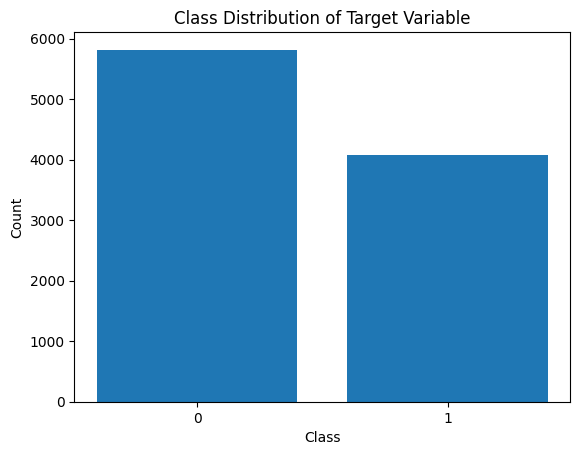

0: 5817
1: 4079


In [5]:
import matplotlib.pyplot as plt

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution of Target Variable')

class_count = data['isCancerous'].value_counts()

# number of samples in each class
class_counts = [class_count[0], class_count[1]]

# create the bar plot
plt.bar(['0', '1'], class_counts)

plt.show()
print("0:", class_count[0])
print("1:", class_count[1])

Observations:
- the classes are imbalanced
- the 0 (Non-Cancerous) class has approximately 1700 more samples

Lets see if we have any null values in the data:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


Observations:
- there are no null values in the data
- the datatypes in the ImageName, and cellTypeName columns are object but it is better to have them as string

Lets examine the statistical analysis of the data:

In [7]:
data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


Lets look at a few randomly selected images in each class to see the variation in the images:

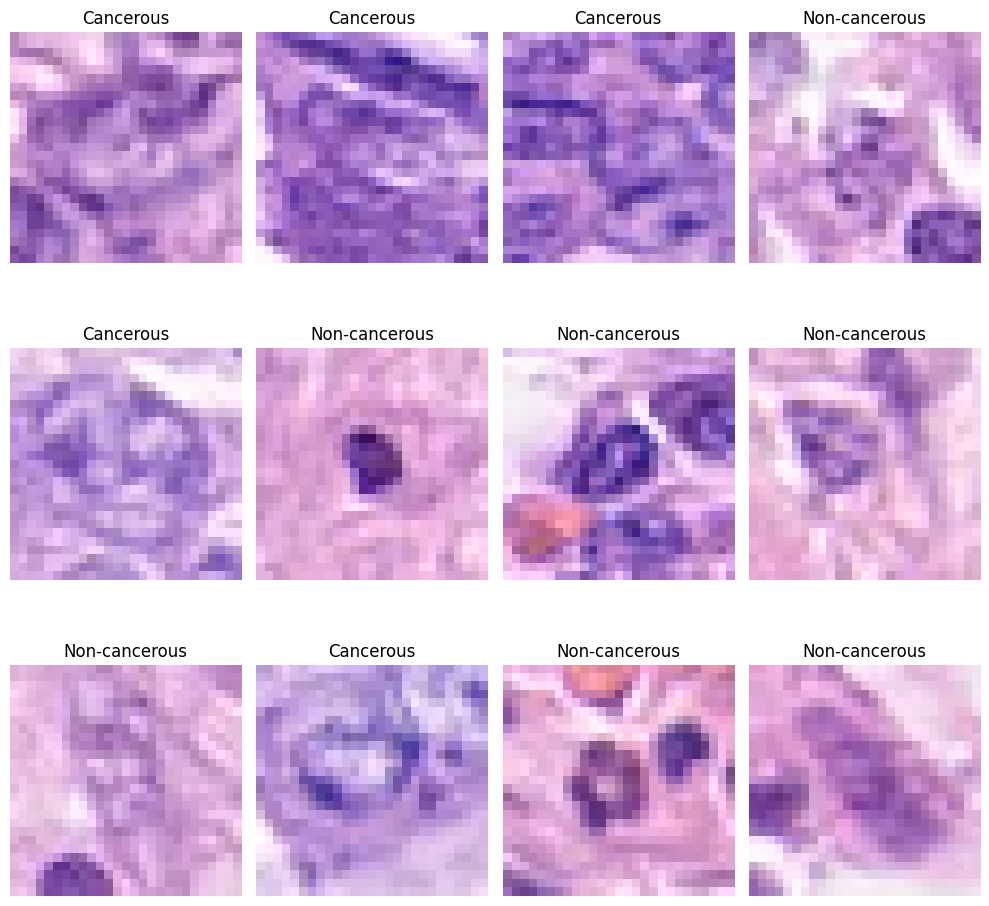

In [8]:
from PIL import Image

# defining class labels
class_labels = ['Non-cancerous', 'Cancerous']

# randomly selecting images
num_samples = 12
sample_df = data.sample(num_samples)

# plotting the images in a grid
fig, axes = plt.subplots(3, 4,  figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image_path = sample_df.iloc[i]['ImageName']
    label = sample_df.iloc[i]['isCancerous']

    # loading and displaying the images
    image = Image.open('./patch_images/' + image_path)
    ax.axis('off')
    ax.set_title(class_labels[label])
    ax.imshow(image)

plt.tight_layout()
plt.show()

Observations:
- the cells are of different sizes and shapes
- some images are brighter than others

Misclassifying the type of cell will be a very costly mistake in terms of the patients health and allocation of medical resources so when choosing a metric we need to choose one like recall which makes sure to minimize false negatives. If we optimize for recall, this might result in an increase in false positives which means that we are now dealing with the same problem. So to minimize false positives and ensure a balance we will also use precision as the other performance metric.

The two performance metrics we will focus on are:
- recall
- precision